In [1]:
import jcopdl, luwiji
jcopdl.__version__, luwiji.__version__

('1.1.9', '1.1.8')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [6]:
bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale = (0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle= True)

In [7]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [8]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

# Architecture and Config

In [9]:
from jcopdl.layers import linear_block, conv_block

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1),
            linear_block(256, 2, activation="lsoftmax")
        )
        
    def forward(self, x):
        return self.fc(self.conv(x))

In [11]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size
})

In [12]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# Training

In [14]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 0.6952 | Test_cost  = 0.6930 | Train_score = 0.5060 | Test_score = 0.5000 |




Epoch     2
Train_cost  = 0.6892 | Test_cost  = 0.6795 | Train_score = 0.5060 | Test_score = 0.6175 |




Epoch     3
Train_cost  = 0.6569 | Test_cost  = 0.6059 | Train_score = 0.6970 | Test_score = 0.7475 |




Epoch     4
Train_cost  = 0.5519 | Test_cost  = 0.5410 | Train_score = 0.7500 | Test_score = 0.6975 |
==> EarlyStop patience =  1 | Best test_score: 0.7475




Epoch     5
Train_cost  = 0.5077 | Test_cost  = 0.5312 | Train_score = 0.7640 | Test_score = 0.7125 |
==> EarlyStop patience =  2 | Best test_score: 0.7475




Epoch     6
Train_cost  = 0.4943 | Test_cost  = 0.5002 | Train_score = 0.7610 | Test_score = 0.7375 |
==> EarlyStop patience =  3 | Best test_score: 0.7475




Epoch     7
Train_cost  = 0.4692 | Test_cost  = 0.4929 | Train_score = 0.7880 | Test_score = 0.7475 |
==> EarlyStop patience =  4 | Best test_score: 0.7475




Epoch     8
Train_cost  = 0.4510 | Test_cost  = 0.4515 | Train_score = 0.8080 | Test_score = 0.7750 |




Epoch     9
Train_cost  = 0.4198 | Test_cost  = 0.3969 | Train_score = 0.8180 | Test_score = 0.8275 |




Epoch    10
Train_cost  = 0.4052 | Test_cost  = 0.4191 | Train_score = 0.8080 | Test_score = 0.8025 |
==> EarlyStop patience =  1 | Best test_score: 0.8275




Epoch    11
Train_cost  = 0.3931 | Test_cost  = 0.3759 | Train_score = 0.8210 | Test_score = 0.8225 |
==> EarlyStop patience =  2 | Best test_score: 0.8275




Epoch    12
Train_cost  = 0.3908 | Test_cost  = 0.3545 | Train_score = 0.8290 | Test_score = 0.8450 |




Epoch    13
Train_cost  = 0.3705 | Test_cost  = 0.3467 | Train_score = 0.8320 | Test_score = 0.8500 |




Epoch    14
Train_cost  = 0.3637 | Test_cost  = 0.3532 | Train_score = 0.8360 | Test_score = 0.8400 |
==> EarlyStop patience =  1 | Best test_score: 0.8500




Epoch    15
Train_cost  = 0.3572 | Test_cost  = 0.3419 | Train_score = 0.8420 | Test_score = 0.8500 |
==> EarlyStop patience =  2 | Best test_score: 0.8500




Epoch    16
Train_cost  = 0.3610 | Test_cost  = 0.3407 | Train_score = 0.8400 | Test_score = 0.8550 |




Epoch    17
Train_cost  = 0.3577 | Test_cost  = 0.3586 | Train_score = 0.8470 | Test_score = 0.8475 |
==> EarlyStop patience =  1 | Best test_score: 0.8550




Epoch    18
Train_cost  = 0.3575 | Test_cost  = 0.3309 | Train_score = 0.8470 | Test_score = 0.8600 |




Epoch    19
Train_cost  = 0.3392 | Test_cost  = 0.3228 | Train_score = 0.8550 | Test_score = 0.8575 |
==> EarlyStop patience =  1 | Best test_score: 0.8600




Epoch    20
Train_cost  = 0.3486 | Test_cost  = 0.3250 | Train_score = 0.8480 | Test_score = 0.8550 |


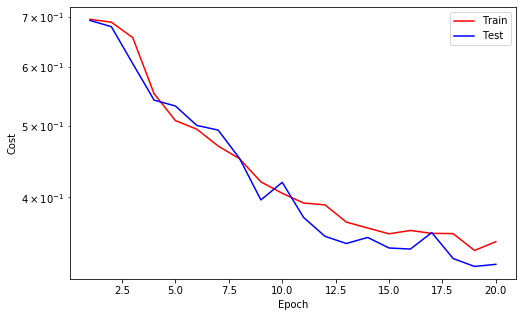

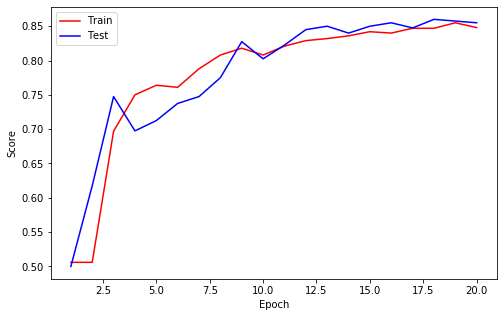

==> EarlyStop patience =  2 | Best test_score: 0.8600




Epoch    21
Train_cost  = 0.3308 | Test_cost  = 0.3290 | Train_score = 0.8730 | Test_score = 0.8600 |
==> EarlyStop patience =  3 | Best test_score: 0.8600




Epoch    22
Train_cost  = 0.3378 | Test_cost  = 0.3110 | Train_score = 0.8620 | Test_score = 0.8700 |




Epoch    23
Train_cost  = 0.3190 | Test_cost  = 0.3101 | Train_score = 0.8580 | Test_score = 0.8725 |




Epoch    24
Train_cost  = 0.3274 | Test_cost  = 0.3273 | Train_score = 0.8540 | Test_score = 0.8525 |
==> EarlyStop patience =  1 | Best test_score: 0.8725




Epoch    25
Train_cost  = 0.3232 | Test_cost  = 0.2912 | Train_score = 0.8560 | Test_score = 0.8775 |




Epoch    26
Train_cost  = 0.3034 | Test_cost  = 0.2892 | Train_score = 0.8790 | Test_score = 0.8800 |




Epoch    27
Train_cost  = 0.3003 | Test_cost  = 0.2951 | Train_score = 0.8730 | Test_score = 0.8850 |




Epoch    28
Train_cost  = 0.3058 | Test_cost  = 0.2891 | Train_score = 0.8760 | Test_score = 0.8825 |
==> EarlyStop patience =  1 | Best test_score: 0.8850




Epoch    29
Train_cost  = 0.3039 | Test_cost  = 0.3387 | Train_score = 0.8690 | Test_score = 0.8525 |
==> EarlyStop patience =  2 | Best test_score: 0.8850




Epoch    30
Train_cost  = 0.3231 | Test_cost  = 0.2862 | Train_score = 0.8630 | Test_score = 0.8675 |
==> EarlyStop patience =  3 | Best test_score: 0.8850




Epoch    31
Train_cost  = 0.2897 | Test_cost  = 0.2710 | Train_score = 0.8770 | Test_score = 0.8975 |




Epoch    32
Train_cost  = 0.2847 | Test_cost  = 0.2707 | Train_score = 0.8830 | Test_score = 0.8775 |
==> EarlyStop patience =  1 | Best test_score: 0.8975




Epoch    33
Train_cost  = 0.2728 | Test_cost  = 0.2959 | Train_score = 0.8850 | Test_score = 0.8625 |
==> EarlyStop patience =  2 | Best test_score: 0.8975




Epoch    34
Train_cost  = 0.2766 | Test_cost  = 0.2610 | Train_score = 0.8920 | Test_score = 0.8775 |
==> EarlyStop patience =  3 | Best test_score: 0.8975




Epoch    35
Train_cost  = 0.2558 | Test_cost  = 0.2453 | Train_score = 0.8960 | Test_score = 0.8825 |
==> EarlyStop patience =  4 | Best test_score: 0.8975




Epoch    36
Train_cost  = 0.2616 | Test_cost  = 0.2451 | Train_score = 0.8910 | Test_score = 0.8900 |
==> EarlyStop patience =  5 | Best test_score: 0.8975
==> Execute Early Stopping at epoch: 36 | Best test_score: 0.8975
==> Best model is saved at model


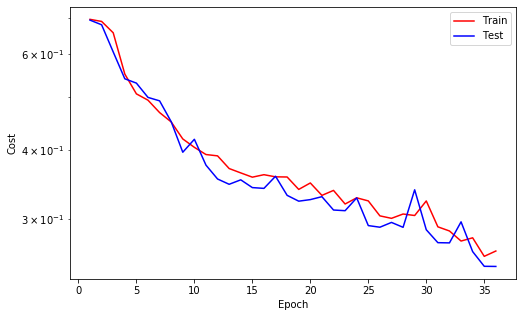

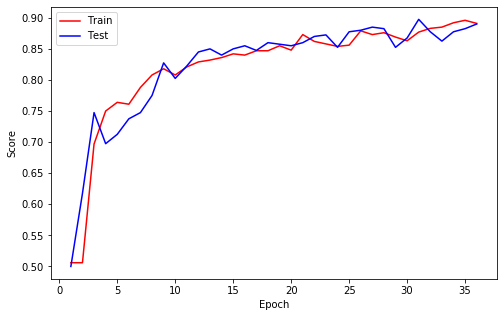

In [15]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Prediction

In [16]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [17]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 0])

In [18]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
[label2cat[pred] for pred in preds]

['invasive',
 'noninvasive',
 'invasive',
 'invasive',
 'noninvasive',
 'invasive',
 'invasive',
 'invasive',
 'invasive',
 'invasive',
 'noninvasive',
 'invasive',
 'invasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'invasive',
 'invasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'invasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'invasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'invasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'invasive',
 'invasive',
 

In [19]:
import matplotlib.pyplot as plt

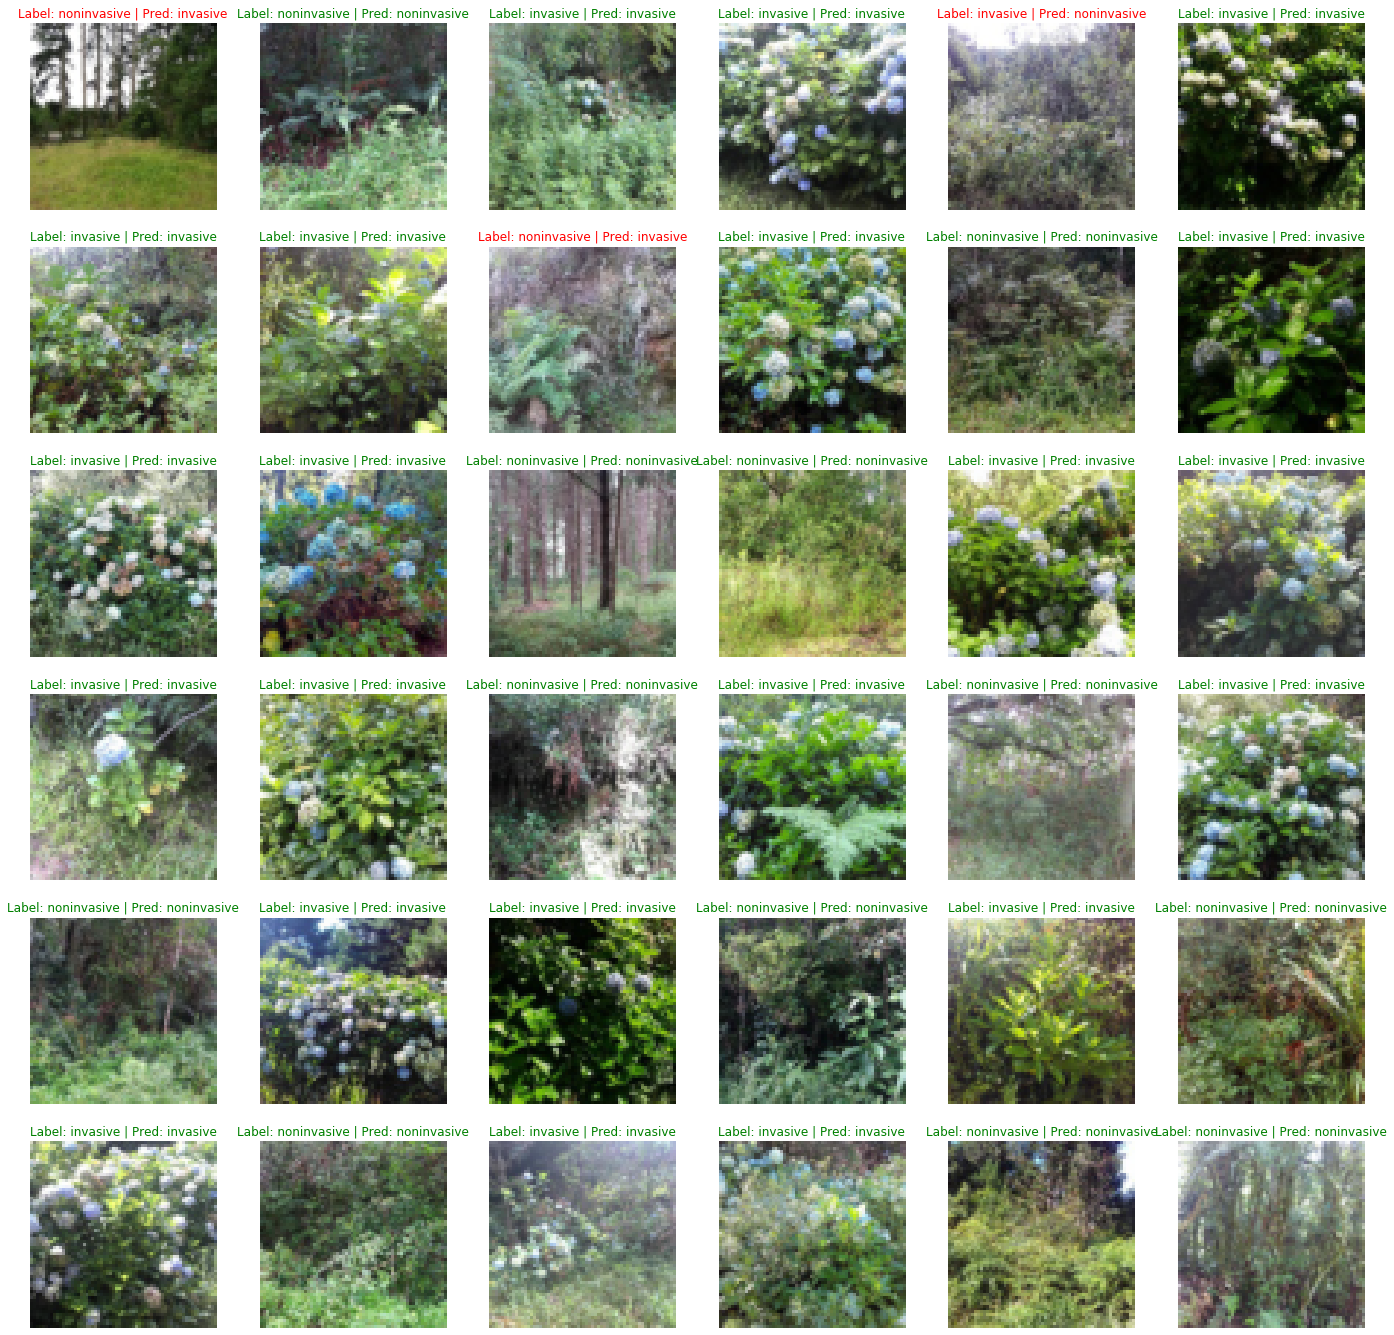

In [23]:
fig, axes = plt.subplots(6, 6, figsize = (24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {'color': 'r'} if label != pred else {'color': 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f'Label: {label} | Pred: {pred}', fontdict = font);
    ax.axis('off');